In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.set_loglevel("info")

In [190]:
# Input
# df_file = "results/evaluation_all.tsv"
# out_folder = "results"

# df_file = "../../CAFA-evaluator_data/cafa4_idpo_evaluation/results_go/evaluation_all.tsv"
# out_folder = "../../CAFA-evaluator_data/cafa4_idpo_evaluation/results_go"

df_file = "../../CAFA-evaluator_data/cafa4_idpo_evaluation/results_idpo/evaluation_all.tsv"
out_folder = "../../CAFA-evaluator_data/cafa4_idpo_evaluation/results_idpo"

# Set to None if you don't want to use it. Results will not be grouped/filtered by team
# names_file = None

names_file = "../../CAFA-evaluator_data/cafa4_idpo_evaluation/names.tsv"

# Cumulate the last column of the cols variable, e.g. "pr" --> precision, so that the curves are monotonic as in CAFA
cumulate = True

# Methods with coverage below this threshold will not be plotted
coverage_threshold = 0.3

# Select a metric
metric, cols = ('f', ['rc', 'pr'])
# metric, cols =  ('wf', ['wrc', 'wpr'])
# metric, cols = ('s', ['ru', 'mi'])

In [191]:
df = pd.read_csv(df_file, sep="\t")
df

,filename,ns,tau,cov,pr,rc,f
0,team_7_1.tsv,disorder_function,0.001,1.00000,0.29286,0.95962,0.44876
1,team_7_1.tsv,disorder_function,0.002,1.00000,0.29286,0.95962,0.44876
2,team_7_1.tsv,disorder_function,0.003,1.00000,0.29286,0.95962,0.44876
3,team_7_1.tsv,disorder_function,0.004,1.00000,0.29286,0.95962,0.44876
4,team_7_1.tsv,disorder_function,0.005,1.00000,0.29286,0.95962,0.44876
...,...,...,...,...,...,...,...
25648,team_2_2.tsv,structural_transition,0.465,0.01124,1.00000,0.01124,0.02222
25649,team_2_2.tsv,structural_transition,0.466,0.01124,1.00000,0.01124,0.02222
25650,team_2_2.tsv,structural_transition,0.467,0.01124,1.00000,0.01124,0.02222
25651,team_2_2.tsv,structural_transition,0.468,0.01124,1.00000,0.01124,0.02222


In [192]:
if names_file is None:
    df['group'] = df['filename']
    df['label'] = df['filename']
    df['is_baseline'] = False
else:
    # Set method information (optional)
    methods = pd.read_csv(names_file, delim_whitespace=True, header=0)
    df = pd.merge(df, methods, on='filename', how='left')
    df['group'].fillna(df['filename'], inplace=True)
    df['label'].fillna(df['filename'], inplace=True)
    if 'is_baseline' not in df:
        df['is_baseline'] = False
    else:
        df['is_baseline'].fillna(False, inplace=True)
    print(methods)
df = df.drop(columns='filename').set_index(['group', 'label', 'ns', 'tau'])
df

        filename                                              group      label
0   team_1_1.tsv                                        Kyle_Renzhi  Team_1_m1
1   team_2_1.tsv                                        Kyle_Renzhi  Team_2_m1
2   team_2_2.tsv  Marco_Marco_Giorgio_Alessandro_Luca_gabriella....  Team_2_m2
3   team_2_3.tsv  Marco_Marco_Giorgio_Alessandro_Luca_gabriella....  Team_2_m3
4   team_3_1.tsv                                     Stavros_Amelia  Team_3_m1
5   team_4_1.tsv                                        Jia-Ming_CT  Team_4_m1
6   team_4_2.tsv                                        Jia-Ming_CT  Team_4_m2
7   team_4_3.tsv                                        Jia-Ming_CT  Team_4_m3
8   team_5_1.tsv              Christopher_Euphemia2020_Akila_Lukasz  Team_5_m1
9   team_5_2.tsv              Christopher_Euphemia2020_Akila_Lukasz  Team_5_m2
10  team_6_1.tsv                                                Wim  Team_6_m1
11  team_6_2.tsv                                    

cov  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  1.00000   
                                                                                   0.002  1.00000   
                                                                                   0.003  1.00000   
                                                                                   0.004  1.00000   
                                                                                   0.005  1.00000   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  0.01124   
                                                                                   0.466  0.01124   
                                                                                   0.467  0.01124   
                                                                                   0.468  0.01124   
                                                                                   0.469  0.01124   

                                                                                               pr  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  0.29286   
                                                                                   0.002  0.29286   
                                                                                   0.003  0.29286   
                                                                                   0.004  0.29286   
                                                                                   0.005  0.29286   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  1.00000   
                                                                                   0.466  1.00000   
                                                                                   0.467  1.00000   
                                                                                   0.468  1.00000   
                                                                                   0.469  1.00000   

                                                                                               rc  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  0.95962   
                                                                                   0.002  0.95962   
                                                                                   0.003  0.95962   
                                                                                   0.004  0.95962   
                                                                                   0.005  0.95962   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  0.01124   
                                                                                   0.466  0.01124   
                                                                                   0.467  0.01124   
                                                                                   0.468  0.01124   
                                                                                   0.469  0.01124   

                                                                                                f  \
group                                              

In [193]:
# Assign colors based on group
cmap = plt.get_cmap('tab20')
df['colors'] = df.index.get_level_values('group')
df['colors'] = pd.factorize(df['colors'])[0]
df['colors'] = df['colors'].apply(lambda x: cmap.colors[x % len(cmap.colors)])
df

cov  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  1.00000   
                                                                                   0.002  1.00000   
                                                                                   0.003  1.00000   
                                                                                   0.004  1.00000   
                                                                                   0.005  1.00000   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  0.01124   
                                                                                   0.466  0.01124   
                                                                                   0.467  0.01124   
                                                                                   0.468  0.01124   
                                                                                   0.469  0.01124   

                                                                                               pr  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  0.29286   
                                                                                   0.002  0.29286   
                                                                                   0.003  0.29286   
                                                                                   0.004  0.29286   
                                                                                   0.005  0.29286   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  1.00000   
                                                                                   0.466  1.00000   
                                                                                   0.467  1.00000   
                                                                                   0.468  1.00000   
                                                                                   0.469  1.00000   

                                                                                               rc  \
group                                              label     ns                    tau              
Hongryul                                           Team_7_m1 disorder_function     0.001  0.95962   
                                                                                   0.002  0.95962   
                                                                                   0.003  0.95962   
                                                                                   0.004  0.95962   
                                                                                   0.005  0.95962   
...                                                                                           ...   
Marco_Marco_Giorgio_Alessandro_Luca_gabriella.t... Team_2_m2 structural_transition 0.465  0.01124   
                                                                                   0.466  0.01124   
                                                                                   0.467  0.01124   
                                                                                   0.468  0.01124   
                                                                                   0.469  0.01124   

                                                                                                f  \
group                                              

In [194]:
# Filter by coverage
df = df[df['cov'] >= coverage_threshold]
df

cov       pr       rc  \
group       label     ns                    tau                                
Hongryul    Team_7_m1 disorder_function     0.001  1.00000  0.29286  0.95962   
                                            0.002  1.00000  0.29286  0.95962   
                                            0.003  1.00000  0.29286  0.95962   
                                            0.004  1.00000  0.29286  0.95962   
                                            0.005  1.00000  0.29286  0.95962   
...                                                    ...      ...      ...   
Jia-Ming_CT Team_4_m3 structural_transition 0.926  0.31461  0.51556  0.24157   
                                            0.927  0.31461  0.51556  0.24157   
                                            0.928  0.31461  0.51556  0.24157   
                                            0.929  0.31461  0.51556  0.24157   
                                            0.930  0.31461  0.51556  0.24157   

                                                         f  is_baseline  \
group       label     ns                    tau                           
Hongryul    Team_7_m1 disorder_function     0.001  0.44876        False   
                                            0.002  0.44876        False   
                                            0.003  0.44876        False   
                                            0.004  0.44876        False   
                                            0.005  0.44876        False   
...                                                    ...          ...   
Jia-Ming_CT Team_4_m3 structural_transition 0.926  0.32899        False   
                                            0.927  0.32899        False   
                                            0.928  0.32899        False   
                                            0.929  0.32899        False   
                                            0.930  0.32899        False   

                                                                                              colors  
group       label     ns                    tau                                                       
Hongryul    Team_7_m1 disorder_function     0.001  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                            0.002  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                            0.003  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                            0.004  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                            0.005  (0.12156862745098039, 0.4666666666666667, 0.70...  
...                                                                                              ...  
Jia-Ming_CT Team_4_m3 structural_transition 0.926  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                            0.927  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                            0.928  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                            0.929  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                            0.930  (0.17254901960784313, 0.6274509803921569, 0.17...  

[13935 rows x 6 columns]

In [195]:
# Identify the best methods and thresholds
index_best = df.groupby(level=['group', 'ns'])[metric].idxmax() if metric in ['f', 'wf'] else df.groupby(['group', 'ns'])[metric].idxmin()
index_best

group              ns                   
Abdulrahman_Rabie  disorder_function        (Abdulrahman_Rabie, Team_8_m1, disorder_functi...
                   structural_state         (Abdulrahman_Rabie, Team_8_m1, structural_stat...
                   structural_transition    (Abdulrahman_Rabie, Team_8_m1, structural_tran...
Hongryul           disorder_function          (Hongryul, Team_7_m1, disorder_function, 0.051)
                   structural_state            (Hongryul, Team_7_m1, structural_state, 0.021)
                   structural_transition    (Hongryul, Team_7_m1, structural_transition, 0...
Jia-Ming_CT        disorder_function        (Jia-Ming_CT, Team_4_m2, disorder_function, 0....
                   structural_state          (Jia-Ming_CT, Team_4_m2, structural_state, 0.48)
                   structural_transition    (Jia-Ming_CT, Team_4_m2, structural_transition...
Kyle_Renzhi        disorder_function        (Kyle_Renzhi, Team_2_m1, disorder_function, 0....
                   

In [196]:
# Filter the dataframe for the best method and threshold
df_best = df.loc[index_best, ['cov', 'colors'] + cols + [metric]]
df_best

cov  \
group             label     ns                    tau              
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.99405   
                            structural_state      0.731  1.00000   
                            structural_transition 0.350  0.98876   
Hongryul          Team_7_m1 disorder_function     0.051  1.00000   
                            structural_state      0.021  1.00000   
                            structural_transition 0.041  1.00000   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  1.00000   
                            structural_state      0.480  1.00000   
                            structural_transition 0.841  1.00000   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.88095   
                            structural_state      0.001  0.99859   
                  Team_1_m1 structural_transition 0.851  0.57303   

                                                                                                    colors  \
group             label     ns                    tau                                                        
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_state      0.731  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_transition 0.350  (0.6823529411764706, 0.7803921568627451, 0.909...   
Hongryul          Team_7_m1 disorder_function     0.051  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_state      0.021  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_transition 0.041  (0.12156862745098039, 0.4666666666666667, 0.70...   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_state      0.480  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_transition 0.841  (0.17254901960784313, 0.6274509803921569, 0.17...   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051     (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      0.001     (1.0, 0.7333333333333333, 0.47058823529411764)   
                  Team_1_m1 structural_transition 0.851     (1.0, 0.7333333333333333, 0.47058823529411764)   

                                                              rc       pr  \
group             label     ns                    tau                       
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.77639  0.59667   
                            structural_state      0.731  0.99435  0.99529   
                            structural_transition 0.350  0.91573  0.77235   
Hongryul          Team_7_m1 disorder_function     0.051  0.77450  0.77778   
                            structural_state      0.021  0.99435  1.00000   
                            structural_transition 0.041  0.94195  0.94944   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  0.70129  0.63889   
                            structural_state      0.480  0.99670  0.61335   
                            structural_transition 0.841  0.94195  0.63296   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.51925  0.56453   
                            structural_state      0.001  0.99294  1.00000   
                  Team_1_m1 structural_transition 0.851  0.52622  0.62092   

                                                               f  
group             label     ns                    tau             
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.67477  
                            structural_state      0.731  0.99482  
                            structural_transition 0.350  0.83795  
Hongryul          Team_7_m1 disorder_function     0.051  0.77614  
                            structural_state      0.021  0.99717  
                   

In [197]:
# Filter the dataframe for the best methods
df_methods = df.reset_index('tau').loc[[ele[:-1] for ele in index_best], ['tau', 'cov', 'colors'] + cols + [metric]].sort_index()

# Makes the curves monotonic. Cumulative max on the last column of the cols variable, e.g. "pr" --> precision
if cumulate:
    if metric in ['f', 'wf']:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummax()
    else:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummin()


# Save to file
df_methods.drop(columns=['colors']).to_csv('{}/fig_{}.tsv'.format(out_folder, metric), float_format="%.3f", sep="\t")
df_methods

tau      cov  \
group             label     ns                                  
Abdulrahman_Rabie Team_8_m1 disorder_function  0.001  1.00000   
                            disorder_function  0.002  1.00000   
                            disorder_function  0.003  1.00000   
                            disorder_function  0.004  1.00000   
                            disorder_function  0.005  1.00000   
...                                              ...      ...   
Kyle_Renzhi       Team_2_m1 structural_state   0.506  0.35593   
                            structural_state   0.507  0.35593   
                            structural_state   0.508  0.35593   
                            structural_state   0.509  0.35593   
                            structural_state   0.510  0.35593   

                                                                                          colors  \
group             label     ns                                                                     
Abdulrahman_Rabie Team_8_m1 disorder_function  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            disorder_function  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            disorder_function  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            disorder_function  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            disorder_function  (0.6823529411764706, 0.7803921568627451, 0.909...   
...                                                                                          ...   
Kyle_Renzhi       Team_2_m1 structural_state      (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      (1.0, 0.7333333333333333, 0.47058823529411764)   

                                                    rc       pr        f  
group             label     ns                                            
Abdulrahman_Rabie Team_8_m1 disorder_function  0.95962  0.29253  0.44838  
                            disorder_function  0.95962  0.29253  0.44838  
                            disorder_function  0.95962  0.29253  0.44838  
                            disorder_function  0.95962  0.29253  0.44838  
                            disorder_function  0.95962  0.29253  0.44838  
...                                                ...      ...      ...  
Kyle_Renzhi       Team_2_m1 structural_state   0.35358  1.00000  0.52243  
                            structural_state   0.35358  1.00000  0.52243  
                            structural_state   0.35358  1.00000  0.52243  
                            structural_state   0.35358  1.00000  0.52243  
                            structural_state   0.35358  1.00000  0.52243  

[7858 rows x 6 columns]

In [198]:
# Calculate the max coverage across all thresholds
df_best['max_cov'] = df_methods.groupby(level=['group', 'label', 'ns'])['cov'].max()
df_best

cov  \
group             label     ns                    tau              
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.99405   
                            structural_state      0.731  1.00000   
                            structural_transition 0.350  0.98876   
Hongryul          Team_7_m1 disorder_function     0.051  1.00000   
                            structural_state      0.021  1.00000   
                            structural_transition 0.041  1.00000   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  1.00000   
                            structural_state      0.480  1.00000   
                            structural_transition 0.841  1.00000   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.88095   
                            structural_state      0.001  0.99859   
                  Team_1_m1 structural_transition 0.851  0.57303   

                                                                                                    colors  \
group             label     ns                    tau                                                        
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_state      0.731  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_transition 0.350  (0.6823529411764706, 0.7803921568627451, 0.909...   
Hongryul          Team_7_m1 disorder_function     0.051  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_state      0.021  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_transition 0.041  (0.12156862745098039, 0.4666666666666667, 0.70...   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_state      0.480  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_transition 0.841  (0.17254901960784313, 0.6274509803921569, 0.17...   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051     (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      0.001     (1.0, 0.7333333333333333, 0.47058823529411764)   
                  Team_1_m1 structural_transition 0.851     (1.0, 0.7333333333333333, 0.47058823529411764)   

                                                              rc       pr  \
group             label     ns                    tau                       
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.77639  0.59667   
                            structural_state      0.731  0.99435  0.99529   
                            structural_transition 0.350  0.91573  0.77235   
Hongryul          Team_7_m1 disorder_function     0.051  0.77450  0.77778   
                            structural_state      0.021  0.99435  1.00000   
                            structural_transition 0.041  0.94195  0.94944   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  0.70129  0.63889   
                            structural_state      0.480  0.99670  0.61335   
                            structural_transition 0.841  0.94195  0.63296   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.51925  0.56453   
                            structural_state      0.001  0.99294  1.00000   
                  Team_1_m1 structural_transition 0.851  0.52622  0.62092   

                                                               f  max_cov  
group             label     ns                    tau                      
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.67477  1.00000  
                            structural_state      0.731  0.99482  1.00000  
                            structural_transition 0.350  0.83795  1.00000  
Hongryul          Team_7_m1 disorder_function     0.051  0.77614  1.00000  
                            stru

In [199]:
# Set a label column for the plot legend
df_best['label'] = df_best.index.get_level_values('label')
df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} C={x['max_cov']:.3f})", axis=1)
df_best

cov  \
group             label     ns                    tau              
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.99405   
                            structural_state      0.731  1.00000   
                            structural_transition 0.350  0.98876   
Hongryul          Team_7_m1 disorder_function     0.051  1.00000   
                            structural_state      0.021  1.00000   
                            structural_transition 0.041  1.00000   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  1.00000   
                            structural_state      0.480  1.00000   
                            structural_transition 0.841  1.00000   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.88095   
                            structural_state      0.001  0.99859   
                  Team_1_m1 structural_transition 0.851  0.57303   

                                                                                                    colors  \
group             label     ns                    tau                                                        
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_state      0.731  (0.6823529411764706, 0.7803921568627451, 0.909...   
                            structural_transition 0.350  (0.6823529411764706, 0.7803921568627451, 0.909...   
Hongryul          Team_7_m1 disorder_function     0.051  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_state      0.021  (0.12156862745098039, 0.4666666666666667, 0.70...   
                            structural_transition 0.041  (0.12156862745098039, 0.4666666666666667, 0.70...   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_state      0.480  (0.17254901960784313, 0.6274509803921569, 0.17...   
                            structural_transition 0.841  (0.17254901960784313, 0.6274509803921569, 0.17...   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051     (1.0, 0.7333333333333333, 0.47058823529411764)   
                            structural_state      0.001     (1.0, 0.7333333333333333, 0.47058823529411764)   
                  Team_1_m1 structural_transition 0.851     (1.0, 0.7333333333333333, 0.47058823529411764)   

                                                              rc       pr  \
group             label     ns                    tau                       
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.77639  0.59667   
                            structural_state      0.731  0.99435  0.99529   
                            structural_transition 0.350  0.91573  0.77235   
Hongryul          Team_7_m1 disorder_function     0.051  0.77450  0.77778   
                            structural_state      0.021  0.99435  1.00000   
                            structural_transition 0.041  0.94195  0.94944   
Jia-Ming_CT       Team_4_m2 disorder_function     0.881  0.70129  0.63889   
                            structural_state      0.480  0.99670  0.61335   
                            structural_transition 0.841  0.94195  0.63296   
Kyle_Renzhi       Team_2_m1 disorder_function     0.051  0.51925  0.56453   
                            structural_state      0.001  0.99294  1.00000   
                  Team_1_m1 structural_transition 0.851  0.52622  0.62092   

                                                               f  max_cov  \
group             label     ns                    tau                       
Abdulrahman_Rabie Team_8_m1 disorder_function     0.371  0.67477  1.00000   
                            structural_state      0.731  0.99482  1.00000   
                            structural_transition 0.350  0.83795  1.00000   
Hongryul          Team_7_m1 disorder_function     0.051  0.77614  1.00000   
                          

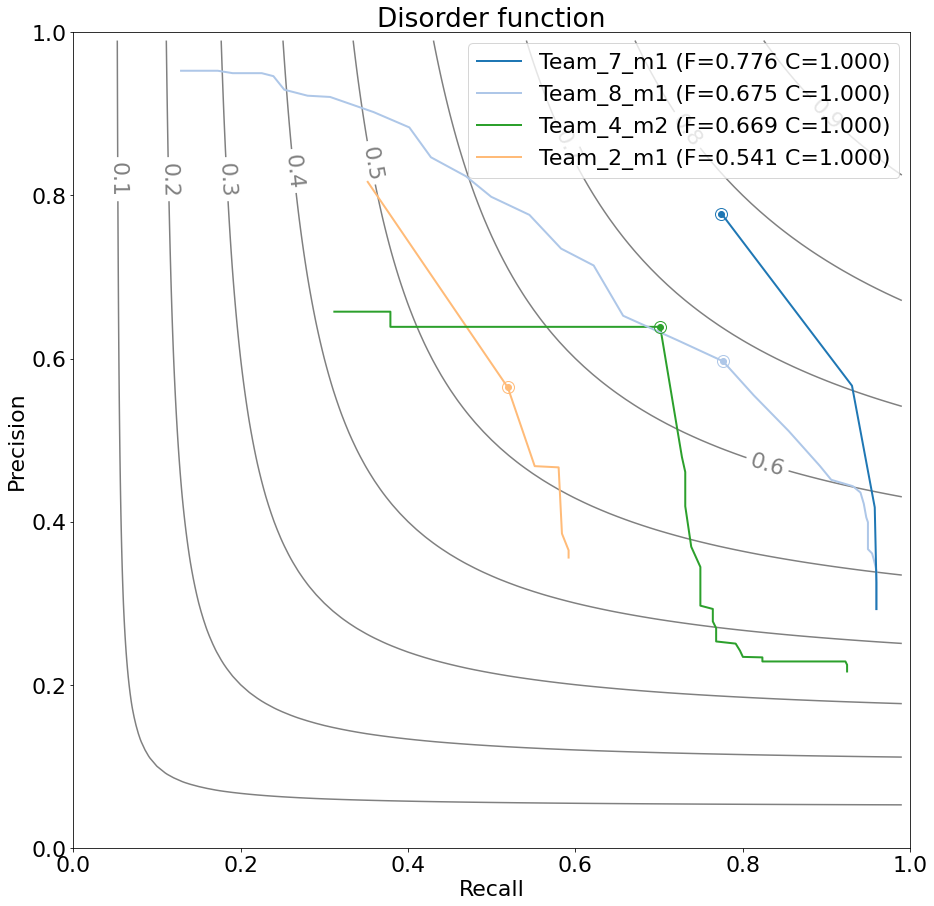

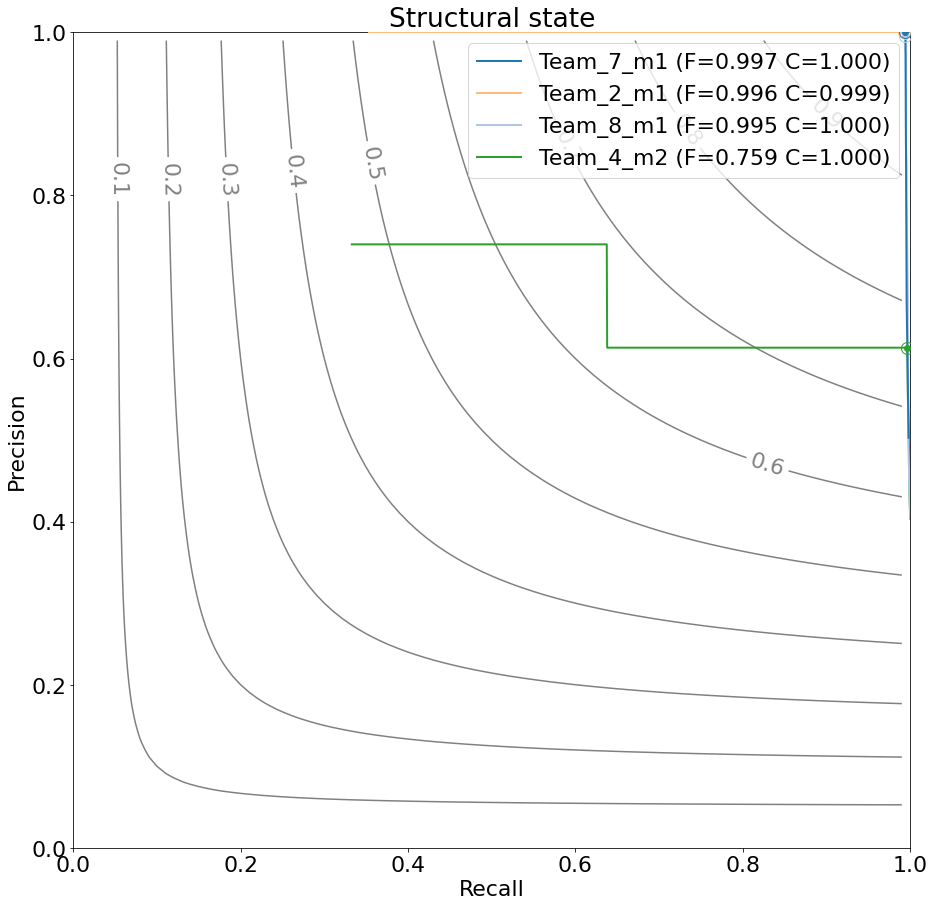

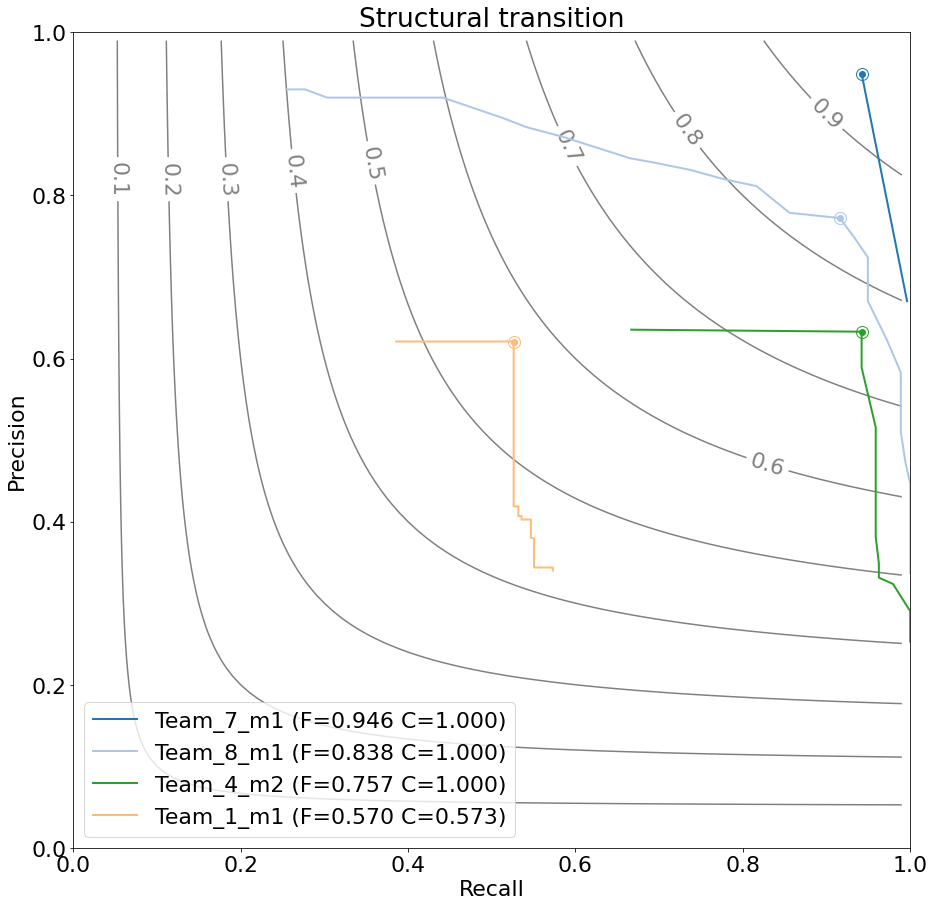

In [200]:
plt.rcParams.update({'font.size': 22})

# F-score contour lines
x = np.arange(0.01, 1, 0.01)
y = np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = 2 * X * Y / (X + Y)

for ns, df_g in df_best.groupby(level='ns'):
    fig, ax = plt.subplots(figsize=(15, 15))

     # Contour lines
    if metric in ['f', 'wf']:
        CS = ax.contour(X, Y, Z, np.arange(0.1, 1.0, 0.1), colors='gray')
        ax.clabel(CS, inline=True)#, fontsize=10)

    # Iterate methods
    for i, (index, row) in enumerate(df_g.sort_values(by=[metric, 'max_cov'], ascending=[False if metric in ['f', 'wf'] else True, False]).iterrows()):
        # print(row)
        data = df_methods.loc[index[:-1]]
        
        # Precision-recall curves
        ax.plot(data[cols[0]], data[cols[1]], color=row['colors'], label=row['label'], lw=2, zorder=500-i)
        
        # F-max dots
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=12, mfc='none', zorder=1000-i)
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=6, zorder=1000-i)

    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlim(0, max(1, df_best.loc[:,:,ns,:][cols[0]].max()))
    plt.ylim(0, max(1, df_best.loc[:,:,ns,:][cols[1]].max()))

    # ax.set_title(ns)
    # ax.set_xlabel(cols[0])
    # ax.set_ylabel(cols[1])
    
    ax.legend()
    ax.set_title(ns.replace('_', ' ').capitalize())
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')



    plt.savefig("{}/fig_{}_{}.png".format(out_folder, metric, ns), bbox_inches='tight')
    # plt.clf()